# Table of Contents
* [faster RCNN](#faster-RCNN)
* [coco eval](#coco-eval)


In [61]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [62]:
import os
import cv2
import PIL.Image as Image

In [45]:
import torchvision
import torchvision.transforms as transforms
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
_ = model.eval()

# faster RCNN

In [39]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
THOR_targets = [
                'AlarmClock',  
                'Apple',
                'BasketBall',
                'Bowl',
                'HousePlant',
                'Laptop',
                'Mug',
                'RemoteControl',
                'Television',
                'Vase',
            ]

In [40]:
# COCO_INSTANCE_CATEGORY_NAMES = [c for c in COCO_INSTANCE_CATEGORY_NAMES_FULL if c in coco_to_thor] + ['__background__']

In [228]:
coco_to_thor = {
    'clock': 'AlarmClock',
    'sports ball': 'BasketBall',
    'apple': 'Apple',
    'bowl': 'Bowl',
    'potted plant': 'HousePlant',
    'laptop': 'Laptop',
    'remote': 'RemoteControl',
    'tv': 'Television',
    'vase': 'Vase',
    'cup': 'Mug'
}

In [104]:
# class ScaleBothSides(object):
#     def __init__(self, size, interpolation=Image.BILINEAR):
#         self.size = size
#         self.interpolation = interpolation

#     def __call__(self, img):
#         return img.resize((self.size, self.size), self.interpolation)

In [105]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [121]:
im_size = 224

In [525]:
all_transforms = transforms.Compose([
    transforms.ToTensor(),
#     normalize,
])

In [264]:
test_img

'./concord_ds/real/12225818185657.jpg'

In [263]:
ls real

ls: real: No such file or directory


In [133]:
img = Image.open(test_img) 
np.array(img).shape

(300, 300, 3)

In [526]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path).convert("RGB")
    transform = all_transforms
    img = transform(img)
    pred = model([img]) 
    img = img.unsqueeze(0)
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    preds = [pred_score.index(x) for x in pred_score if x > threshold]
    if not preds:
        return [], [], []
    pred_t = preds[-1] 
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class, pred_score[:pred_t+1]

In [527]:
boxes, pred_cls, pred_scores = get_prediction(test_img, 0.1) # Get predictions
_ = [print(d) for d in list(zip(boxes, pred_cls, pred_scores))]

([(115.90579, 229.72809), (154.38596, 259.05902)], 'cup', 0.99923563)
([(97.87631, 101.31964), (186.7371, 159.32211)], 'tv', 0.87131375)
([(199.71075, 133.27707), (208.19756, 158.98477)], 'bottle', 0.6986647)
([(187.37155, 157.16666), (236.98485, 161.53835)], 'sink', 0.5193608)
([(92.263756, 101.63045), (189.01598, 159.18588)], 'laptop', 0.48429236)
([(245.40953, 140.5982), (267.49594, 161.89795)], 'vase', 0.4182731)
([(211.51424, 233.37106), (243.23204, 264.96494)], 'cup', 0.3774385)
([(182.0608, 154.8603), (245.39333, 161.72583)], 'sink', 0.19972333)
([(244.09564, 140.5399), (266.62558, 162.23563)], 'apple', 0.15451063)
([(185.23831, 158.96793), (239.92395, 162.30742)], 'sink', 0.147935)
([(77.60414, 165.42044), (290.1327, 296.17737)], 'dining table', 0.12985688)
([(74.08182, 148.89076), (296.55252, 300.0)], 'refrigerator', 0.12346291)
([(188.9063, 156.85294), (226.4887, 160.03897)], 'sink', 0.118218854)
([(210.6181, 232.46013), (243.47604, 265.37305)], 'handbag', 0.10919585)


In [490]:
def object_detection(img_path, threshold=0.5, rect_th=1, text_size=1, text_th=1):
    boxes, pred_cls, scores = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(255, 0, 255), thickness=rect_th) 
        cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (255, 0, 255) ,thickness=text_th) 
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.imshow(img)
    plt.show()

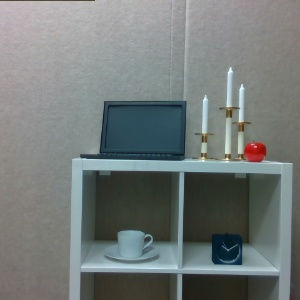

In [541]:
img_id = 12225818185657
test_sim = f'./concord_ds/sim_exact/{img_id}.jpg'
test_real = f'./concord_ds/real/{img_id}.jpg'

imgs = cv2.imread(test_sim) 
imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
Image.fromarray(imgs)

imgr = cv2.imread(test_real) 
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)
Image.fromarray(imgr)

In [552]:
thresh = 0.1

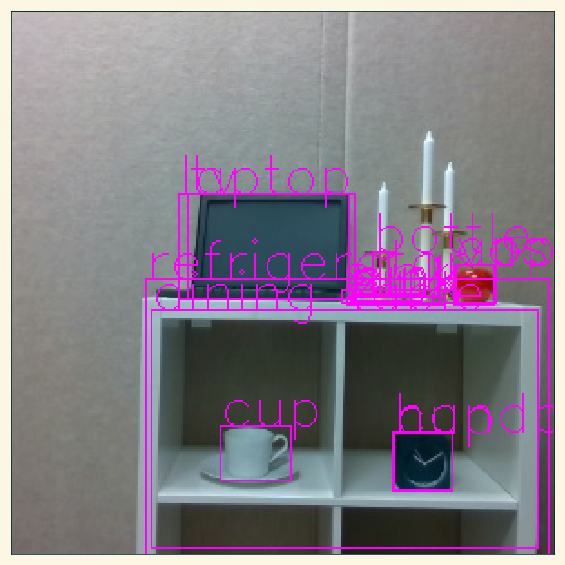

In [553]:
object_detection(test_real, thresh)

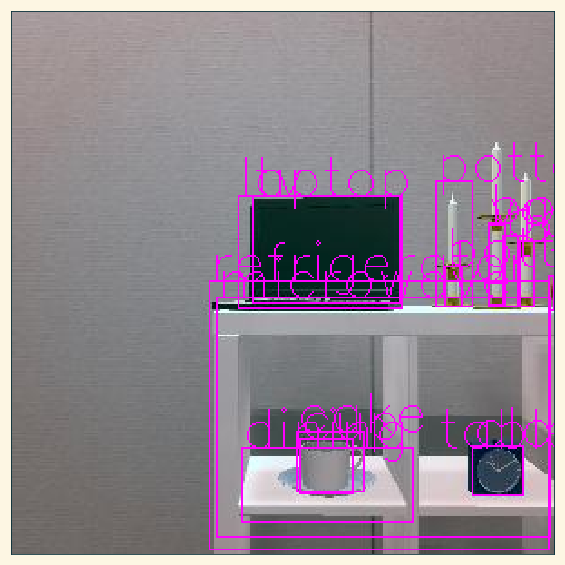

In [554]:
object_detection(test_sim, thresh)

In [555]:
boxes, pred_cls, scores = get_prediction(test_real, thresh) # Get predictions
_ = [print(d) for d in list(zip(boxes, pred_cls, pred_scores))]

([(115.90579, 229.72809), (154.38596, 259.05902)], 'cup', 0.99923563)
([(97.87631, 101.31964), (186.7371, 159.32211)], 'tv', 0.87131375)
([(199.71075, 133.27707), (208.19756, 158.98477)], 'bottle', 0.6986647)
([(187.37155, 157.16666), (236.98485, 161.53835)], 'sink', 0.5193608)
([(92.263756, 101.63045), (189.01598, 159.18588)], 'laptop', 0.48429236)
([(245.40953, 140.5982), (267.49594, 161.89795)], 'vase', 0.4182731)
([(211.51424, 233.37106), (243.23204, 264.96494)], 'cup', 0.3774385)
([(182.0608, 154.8603), (245.39333, 161.72583)], 'sink', 0.19972333)
([(244.09564, 140.5399), (266.62558, 162.23563)], 'apple', 0.15451063)
([(185.23831, 158.96793), (239.92395, 162.30742)], 'sink', 0.147935)
([(77.60414, 165.42044), (290.1327, 296.17737)], 'dining table', 0.12985688)
([(74.08182, 148.89076), (296.55252, 300.0)], 'refrigerator', 0.12346291)
([(188.9063, 156.85294), (226.4887, 160.03897)], 'sink', 0.118218854)
([(210.6181, 232.46013), (243.47604, 265.37305)], 'handbag', 0.10919585)


In [556]:
boxes, pred_cls, scores = get_prediction(test_sim, thresh) # Get predictions
_ = [print(d) for d in list(zip(boxes, pred_cls, pred_scores))]

([(254.10466, 240.80127), (282.20148, 267.7336)], 'clock', 0.99923563)
([(159.23729, 236.8262), (188.89058, 266.24557)], 'cup', 0.87131375)
([(133.87338, 102.08679), (214.5126, 161.176)], 'tv', 0.6986647)
([(263.3413, 117.12792), (272.648, 163.1838)], 'bottle', 0.5193608)
([(239.68933, 141.30435), (248.32669, 163.20496)], 'bottle', 0.48429236)
([(280.09317, 127.81847), (288.52856, 163.05225)], 'bottle', 0.4182731)
([(127.62195, 241.43677), (221.52911, 282.5054)], 'dining table', 0.3774385)
([(125.12009, 102.54132), (215.02794, 164.00085)], 'laptop', 0.19972333)
([(263.33466, 118.63391), (272.6475, 162.32733)], 'vase', 0.15451063)
([(109.575806, 149.2394), (296.26343, 297.93118)], 'refrigerator', 0.147935)
([(271.37555, 124.07517), (279.95337, 163.9783)], 'bottle', 0.12985688)
([(113.08963, 158.53635), (297.7043, 290.3616)], 'microwave', 0.12346291)
([(296.03674, 146.5061), (299.86133, 165.50519)], 'bottle', 0.118218854)
([(234.2651, 94.40914), (254.5051, 163.06964)], 'potted plant', 0.

# build coco formatted ds

## det

In [171]:
base_gt_ds = {
    'info': {'description': 'real_val_2_2',
         'url': '',
         'version': '1.0',
         'year': 2019,
         'contributor': 'AI2',
         'date_created': '2019/11/14'},
    'licenses': [],
    'categories': [{'supercategory': 'person', 'id': 1, 'name': 'person'},
                 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
                 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
                 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
                 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
                 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
                 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
                 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
                 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
                 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
                 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
                 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
                 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
                 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
                 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
                 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
                 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},
                 {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
                 {'supercategory': 'animal', 'id': 20, 'name': 'sheep'},
                 {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
                 {'supercategory': 'animal', 'id': 22, 'name': 'elephant'},
                 {'supercategory': 'animal', 'id': 23, 'name': 'bear'},
                 {'supercategory': 'animal', 'id': 24, 'name': 'zebra'},
                 {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'},
                 {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'},
                 {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'},
                 {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
                 {'supercategory': 'accessory', 'id': 32, 'name': 'tie'},
                 {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'},
                 {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'},
                 {'supercategory': 'sports', 'id': 35, 'name': 'skis'},
                 {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'},
                 {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'},
                 {'supercategory': 'sports', 'id': 38, 'name': 'kite'},
                 {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'},
                 {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'},
                 {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'},
                 {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'},
                 {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'},
                 {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
                 {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'},
                 {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'},
                 {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'},
                 {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'},
                 {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'},
                 {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'},
                 {'supercategory': 'food', 'id': 52, 'name': 'banana'},
                 {'supercategory': 'food', 'id': 53, 'name': 'apple'},
                 {'supercategory': 'food', 'id': 54, 'name': 'sandwich'},
                 {'supercategory': 'food', 'id': 55, 'name': 'orange'},
                 {'supercategory': 'food', 'id': 56, 'name': 'broccoli'},
                 {'supercategory': 'food', 'id': 57, 'name': 'carrot'},
                 {'supercategory': 'food', 'id': 58, 'name': 'hot dog'},
                 {'supercategory': 'food', 'id': 59, 'name': 'pizza'},
                 {'supercategory': 'food', 'id': 60, 'name': 'donut'},
                 {'supercategory': 'food', 'id': 61, 'name': 'cake'},
                 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
                 {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
                 {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'},
                 {'supercategory': 'furniture', 'id': 65, 'name': 'bed'},
                 {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'},
                 {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'},
                 {'supercategory': 'electronic', 'id': 72, 'name': 'tv'},
                 {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
                 {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'},
                 {'supercategory': 'electronic', 'id': 75, 'name': 'remote'},
                 {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'},
                 {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'},
                 {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'},
                 {'supercategory': 'appliance', 'id': 79, 'name': 'oven'},
                 {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'},
                 {'supercategory': 'appliance', 'id': 81, 'name': 'sink'},
                 {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'},
                 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
                 {'supercategory': 'indoor', 'id': 85, 'name': 'clock'},
                 {'supercategory': 'indoor', 'id': 86, 'name': 'vase'},
                 {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'},
                 {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'},
                 {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'},
                 {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]
    }

In [172]:
test_img

'./concord_ds/real/12225818185657.jpg'

In [359]:
def build_img_field(img, img_id):
    base_image = {
      'license': 0,
      'file_name': img,
      'coco_url': '',
      'height': 300,
      'width': 300,
      'date_captured': '',
      'flickr_url': '',
      'id': img_id
    }
    return base_image

def conv_det_bbox(box):
    (x1, y1), (x2, y2) = box
    new_box = [x1, y1, x2 - x1, y2 -y1]
    new_box = [float(c) for c in new_box]
    return new_box

def build_ann_field(bbox, img_id, cat_id, aid):
    form_bbox = conv_det_bbox(bbox)
    base_anno = {'segmentation': [[]],
                  'area': box_area(form_bbox),
                  'iscrowd': 0,
                  'image_id': img_id,
                  'bbox': form_bbox,
                  'category_id': cat_id,
                  'id': aid}
    return base_anno

In [379]:
# def build_det_ds(raw_gt):
#     base_gt_ds = {
#     'info': {'description': 'sim_val_2_2',
#          'url': '',
#          'version': '1.0',
#          'year': 2019,
#          'contributor': 'AI2',
#          'date_created': '2019/11/14'},
#     'licenses': [],
#     'images': [],
#     'annotations': [],
#     'categories': [{'supercategory': 'person', 'id': 1, 'name': 'person'},
#                  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
#                  {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
#                  {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
#                  {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
#                  {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
#                  {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
#                  {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
#                  {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
#                  {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
#                  {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
#                  {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
#                  {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
#                  {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
#                  {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
#                  {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
#                  {'supercategory': 'animal', 'id': 18, 'name': 'dog'},
#                  {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
#                  {'supercategory': 'animal', 'id': 20, 'name': 'sheep'},
#                  {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
#                  {'supercategory': 'animal', 'id': 22, 'name': 'elephant'},
#                  {'supercategory': 'animal', 'id': 23, 'name': 'bear'},
#                  {'supercategory': 'animal', 'id': 24, 'name': 'zebra'},
#                  {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'},
#                  {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'},
#                  {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'},
#                  {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
#                  {'supercategory': 'accessory', 'id': 32, 'name': 'tie'},
#                  {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'},
#                  {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'},
#                  {'supercategory': 'sports', 'id': 35, 'name': 'skis'},
#                  {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'},
#                  {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'},
#                  {'supercategory': 'sports', 'id': 38, 'name': 'kite'},
#                  {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'},
#                  {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'},
#                  {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'},
#                  {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'},
#                  {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'},
#                  {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
#                  {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'},
#                  {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'},
#                  {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'},
#                  {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'},
#                  {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'},
#                  {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'},
#                  {'supercategory': 'food', 'id': 52, 'name': 'banana'},
#                  {'supercategory': 'food', 'id': 53, 'name': 'apple'},
#                  {'supercategory': 'food', 'id': 54, 'name': 'sandwich'},
#                  {'supercategory': 'food', 'id': 55, 'name': 'orange'},
#                  {'supercategory': 'food', 'id': 56, 'name': 'broccoli'},
#                  {'supercategory': 'food', 'id': 57, 'name': 'carrot'},
#                  {'supercategory': 'food', 'id': 58, 'name': 'hot dog'},
#                  {'supercategory': 'food', 'id': 59, 'name': 'pizza'},
#                  {'supercategory': 'food', 'id': 60, 'name': 'donut'},
#                  {'supercategory': 'food', 'id': 61, 'name': 'cake'},
#                  {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
#                  {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
#                  {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'},
#                  {'supercategory': 'furniture', 'id': 65, 'name': 'bed'},
#                  {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'},
#                  {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'},
#                  {'supercategory': 'electronic', 'id': 72, 'name': 'tv'},
#                  {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
#                  {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'},
#                  {'supercategory': 'electronic', 'id': 75, 'name': 'remote'},
#                  {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'},
#                  {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'},
#                  {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'},
#                  {'supercategory': 'appliance', 'id': 79, 'name': 'oven'},
#                  {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'},
#                  {'supercategory': 'appliance', 'id': 81, 'name': 'sink'},
#                  {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'},
#                  {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
#                  {'supercategory': 'indoor', 'id': 85, 'name': 'clock'},
#                  {'supercategory': 'indoor', 'id': 86, 'name': 'vase'},
#                  {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'},
#                  {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'},
#                  {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'},
#                  {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]
#     }
#     running_ann_indx = 0
#     for img_n, annos in raw_gt.items():
# #         if len(annos) == 0:
# #             continue
#         img_id = img_n
#         img_field = build_img_field(img_id, img_id)
#         base_gt_ds['images'].append(img_field)
#         for anno in annos:
#             bbox, cat = anno
#             anno_field = build_ann_field(bbox, img_id, COCO_INSTANCE_CATEGORY_NAMES.index(cat), running_ann_indx)
#             running_ann_indx += 1
#             base_gt_ds['annotations'].append(anno_field)
#     return base_gt_ds

In [ ]:
[{
"image_id": int, "category_id": int, "bbox": [x,y,width,height], "score": float,
}]

In [392]:
def build_det_ds(raw_gt):
    base_gt_ds = []
    for img_n, annos in raw_gt.items():
        for anno in annos:
            bbox, cat, score = anno
            cat_id = COCO_INSTANCE_CATEGORY_NAMES.index(cat)
            form_bbox  = conv_det_bbox(bbox)
            base_gt_ds.append({
                            "image_id": img_n, "category_id": cat_id, "bbox":form_bbox, "score": float(score),
                            })
    return base_gt_ds

In [533]:
with open ('real_preds.pkl', 'rb') as f:
    det_data = pickle.load(f)

det_coco_ds = build_det_ds(det_data)

with open('real_val_2_2_det.json', 'w') as f:
    json.dump(det_coco_ds, f, indent=3)

In [534]:
with open ('sim_preds.pkl', 'rb') as f:
    det_data = pickle.load(f)

det_coco_ds = build_det_ds(det_data)

with open('sim_val_2_2_det.json', 'w') as f:
    json.dump(det_coco_ds, f, indent=3)

## gt

In [178]:
with open('turk_obj_d_evel/loc_res.json', 'r') as f:
    raw_gt = json.load(f)

In [184]:
samp_res = list(raw_gt.items())[0][1]

In [185]:
samp_res

[{'box': [1, 137, 37, 160], 'action': 'bowl'},
 {'box': [40, 134, 65, 166], 'action': 'mug'}]

In [227]:
coco_to_thor

{'clock': 'AlarmClock',
 'sports ball': 'BasketBall',
 'apple': 'Apple',
 'bowl': 'Bowl',
 'potted plant': 'HousePlant',
 'laptop': 'Laptop',
 'remote': 'RemoteControl',
 'tv': 'Television',
 'vase': 'Vase'}

In [230]:
thor_to_coco  = {v.lower(): k for k, v in coco_to_thor.items()}

In [433]:
def build_img_field_gt(img, img_id):
    base_image = {
      'license': 0,
      'file_name': img,
      'coco_url': '',
      'height': 300,
      'width': 300,
      'date_captured': '',
      'flickr_url': '',
      'id': img_id
    }
    return base_image

def convert_gt_bbox(box):
    x1, y1, x2, y2 = box
    new_box = [x1, y1, x2 - x1, y2 -y1]
    new_box = [float(c) for c in new_box]
    return new_box

def box_area(box):
    return box[2] * box[3]

def lookup_coco_cat_id(cat):
    coco_cat = thor_to_coco[cat.lower()]
    return COCO_INSTANCE_CATEGORY_NAMES.index(coco_cat)


def build_ann_field_gt(bbox, img_id, cat_id, aid):
    form_bbox = convert_gt_bbox(bbox)
    base_anno = {'segmentation': [[]],
                  'area': box_area(form_bbox),
                  'iscrowd': 0,
                  'image_id': img_id,
                  'bbox': form_bbox,
                  'category_id': cat_id,
                  'id': aid}
    return base_anno

In [421]:
def build_gt_ds(raw_gt):
    base_gt_ds = {
    'info': {'description': 'real_val_2_2',
         'url': '',
         'version': '1.0',
         'year': 2019,
         'contributor': 'AI2',
         'date_created': '2019/11/14'},
    'licenses': [],
    'images': [],
    'annotations': [],
    'categories': [{'supercategory': 'person', 'id': 1, 'name': 'person'},
                 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
                 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
                 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
                 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
                 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
                 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
                 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
                 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
                 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
                 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
                 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
                 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
                 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
                 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
                 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
                 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},
                 {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
                 {'supercategory': 'animal', 'id': 20, 'name': 'sheep'},
                 {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
                 {'supercategory': 'animal', 'id': 22, 'name': 'elephant'},
                 {'supercategory': 'animal', 'id': 23, 'name': 'bear'},
                 {'supercategory': 'animal', 'id': 24, 'name': 'zebra'},
                 {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'},
                 {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'},
                 {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'},
                 {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
                 {'supercategory': 'accessory', 'id': 32, 'name': 'tie'},
                 {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'},
                 {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'},
                 {'supercategory': 'sports', 'id': 35, 'name': 'skis'},
                 {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'},
                 {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'},
                 {'supercategory': 'sports', 'id': 38, 'name': 'kite'},
                 {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'},
                 {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'},
                 {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'},
                 {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'},
                 {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'},
                 {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
                 {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'},
                 {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'},
                 {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'},
                 {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'},
                 {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'},
                 {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'},
                 {'supercategory': 'food', 'id': 52, 'name': 'banana'},
                 {'supercategory': 'food', 'id': 53, 'name': 'apple'},
                 {'supercategory': 'food', 'id': 54, 'name': 'sandwich'},
                 {'supercategory': 'food', 'id': 55, 'name': 'orange'},
                 {'supercategory': 'food', 'id': 56, 'name': 'broccoli'},
                 {'supercategory': 'food', 'id': 57, 'name': 'carrot'},
                 {'supercategory': 'food', 'id': 58, 'name': 'hot dog'},
                 {'supercategory': 'food', 'id': 59, 'name': 'pizza'},
                 {'supercategory': 'food', 'id': 60, 'name': 'donut'},
                 {'supercategory': 'food', 'id': 61, 'name': 'cake'},
                 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
                 {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
                 {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'},
                 {'supercategory': 'furniture', 'id': 65, 'name': 'bed'},
                 {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'},
                 {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'},
                 {'supercategory': 'electronic', 'id': 72, 'name': 'tv'},
                 {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
                 {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'},
                 {'supercategory': 'electronic', 'id': 75, 'name': 'remote'},
                 {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'},
                 {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'},
                 {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'},
                 {'supercategory': 'appliance', 'id': 79, 'name': 'oven'},
                 {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'},
                 {'supercategory': 'appliance', 'id': 81, 'name': 'sink'},
                 {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'},
                 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
                 {'supercategory': 'indoor', 'id': 85, 'name': 'clock'},
                 {'supercategory': 'indoor', 'id': 86, 'name': 'vase'},
                 {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'},
                 {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'},
                 {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'},
                 {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]
    }
    running_ann_indx = 0
    for img_n, annos in raw_gt.items():
        if len(annos) == 0:
            continue
        img_id = img_n.split('.')[0]
        img_field = build_img_field_gt(img_id, img_id)
        base_gt_ds['images'].append(img_field)
        for anno in annos:
            if anno['action'] == 'none':
                continue
            anno_field = build_ann_field_gt(anno['box'], img_id, lookup_coco_cat_id(anno['action']), running_ann_indx)
            running_ann_indx += 1
            base_gt_ds['annotations'].append(anno_field)
    return base_gt_ds

In [457]:
real_val_2_2_gt = build_gt_ds(raw_gt)

In [458]:
with open('real_val_2_2_gt.json', 'w') as f:
    json.dump(real_val_2_2_gt, f, indent=3)

In [276]:
real_image_names = [i['file_name'] + '.jpg' for i in real_val_2_2_gt['images']]

In [280]:
import pickle
with open('real_image_names.pkl', 'wb') as f:
    pickle.dump(real_image_names, f)

In [277]:
len(real_image_names)

455

In [188]:
convert_gt_bbox(samp_res[0]['box'])

[1.0, 137.0, 36.0, 23.0]

In [401]:
with open("raw_simdets.pkl", 'rb') as f:
        sim_gt = pickle.load(f)

In [449]:
def sim_lookup_coco_cat_id(cat):
    coco_cat = thor_to_coco.get(cat.lower(), '')
    if not coco_cat:
        return None
    return COCO_INSTANCE_CATEGORY_NAMES.index(coco_cat)

In [452]:
def build_sim_gt_ds(raw_gt):
    base_gt_ds = {
    'info': {'description': 'real_val_2_2',
         'url': '',
         'version': '1.0',
         'year': 2019,
         'contributor': 'AI2',
         'date_created': '2019/11/14'},
    'licenses': [],
    'images': [],
    'annotations': [],
    'categories': [{'supercategory': 'person', 'id': 1, 'name': 'person'},
                 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
                 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
                 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
                 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
                 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
                 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
                 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
                 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
                 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
                 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
                 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
                 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
                 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
                 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
                 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
                 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},
                 {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
                 {'supercategory': 'animal', 'id': 20, 'name': 'sheep'},
                 {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
                 {'supercategory': 'animal', 'id': 22, 'name': 'elephant'},
                 {'supercategory': 'animal', 'id': 23, 'name': 'bear'},
                 {'supercategory': 'animal', 'id': 24, 'name': 'zebra'},
                 {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'},
                 {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'},
                 {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'},
                 {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
                 {'supercategory': 'accessory', 'id': 32, 'name': 'tie'},
                 {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'},
                 {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'},
                 {'supercategory': 'sports', 'id': 35, 'name': 'skis'},
                 {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'},
                 {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'},
                 {'supercategory': 'sports', 'id': 38, 'name': 'kite'},
                 {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'},
                 {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'},
                 {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'},
                 {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'},
                 {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'},
                 {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
                 {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'},
                 {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'},
                 {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'},
                 {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'},
                 {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'},
                 {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'},
                 {'supercategory': 'food', 'id': 52, 'name': 'banana'},
                 {'supercategory': 'food', 'id': 53, 'name': 'apple'},
                 {'supercategory': 'food', 'id': 54, 'name': 'sandwich'},
                 {'supercategory': 'food', 'id': 55, 'name': 'orange'},
                 {'supercategory': 'food', 'id': 56, 'name': 'broccoli'},
                 {'supercategory': 'food', 'id': 57, 'name': 'carrot'},
                 {'supercategory': 'food', 'id': 58, 'name': 'hot dog'},
                 {'supercategory': 'food', 'id': 59, 'name': 'pizza'},
                 {'supercategory': 'food', 'id': 60, 'name': 'donut'},
                 {'supercategory': 'food', 'id': 61, 'name': 'cake'},
                 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
                 {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
                 {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'},
                 {'supercategory': 'furniture', 'id': 65, 'name': 'bed'},
                 {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'},
                 {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'},
                 {'supercategory': 'electronic', 'id': 72, 'name': 'tv'},
                 {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
                 {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'},
                 {'supercategory': 'electronic', 'id': 75, 'name': 'remote'},
                 {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'},
                 {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'},
                 {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'},
                 {'supercategory': 'appliance', 'id': 79, 'name': 'oven'},
                 {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'},
                 {'supercategory': 'appliance', 'id': 81, 'name': 'sink'},
                 {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'},
                 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
                 {'supercategory': 'indoor', 'id': 85, 'name': 'clock'},
                 {'supercategory': 'indoor', 'id': 86, 'name': 'vase'},
                 {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'},
                 {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'},
                 {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'},
                 {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]
    }
    running_ann_indx = 0
    for img_n, annos in raw_gt.items():
        if len(annos) == 0:
            continue
        img_id = img_n.split('.')[0]
        img_field = build_img_field_gt(img_id, img_id)
        base_gt_ds['images'].append(img_field)
        for obj_name, anno in annos.items():
#             print(obj_name, anno)
            coco_id = sim_lookup_coco_cat_id(obj_name)
#             print(coco_id)
            if not coco_id:
                continue
            anno_field = build_ann_field_gt(anno[0], img_id, coco_id , running_ann_indx)
            running_ann_indx += 1
            base_gt_ds['annotations'].append(anno_field)
    return base_gt_ds

In [453]:
sim_gt_ds = build_sim_gt_ds(sim_gt)

In [456]:
with open('sim_val_2_2_gt.json', 'w') as f:
    json.dump(sim_gt_ds, f, indent=3)

# coco eval

In [153]:
import torch

In [157]:
import torchnet as tnt

In [149]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.

    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation

    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision